### Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [35]:
from sklearn.model_selection import train_test_split , GridSearchCV\
        , StratifiedKFold , TimeSeriesSplit,KFold,cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline


In [36]:
df = pd.read_csv('train.csv',index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv('test.csv',parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)'
                        ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})

df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)'
                                  ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})

In [68]:
df

,Date,y,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
ID,,,,,,,,,,,,,,
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,2018-11-20,1317,19,8.7,34,2.2,1857,-6.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
5756,2018-11-20,1078,20,8.5,32,2.6,1789,-7.2,0.0,0.0,0.0,Autumn,No Holiday,Yes
5757,2018-11-20,1020,21,8.8,37,3.8,1750,-5.1,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [72]:
visualization_df = df.copy()
visualization_df['Date'] = pd.to_datetime(visualization_df['Date'])
visualization_df = visualization_df.select_dtypes(exclude='object')
visualization_df['Week Days'] = visualization_df['Date'].apply(lambda x:x.dayofweek)
visualization_df['month']= visualization_df['Date'].apply(lambda x:x.month)
visualization_df.head()

,Date,y,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Week Days,month
ID,,,,,,,,,,,,,
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,12
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,12
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,12
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,12
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,12


# Visualization

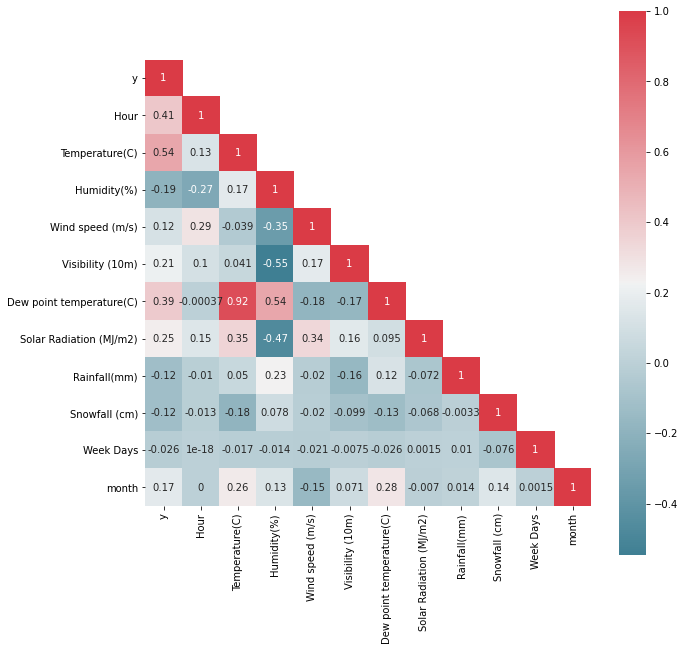

In [73]:
corr = visualization_df.corr()
corr_mask = np.ones_like(corr)
corr_mask[np.tril_indices_from(corr_mask)] = False

plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=corr_mask, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)
plt.show()

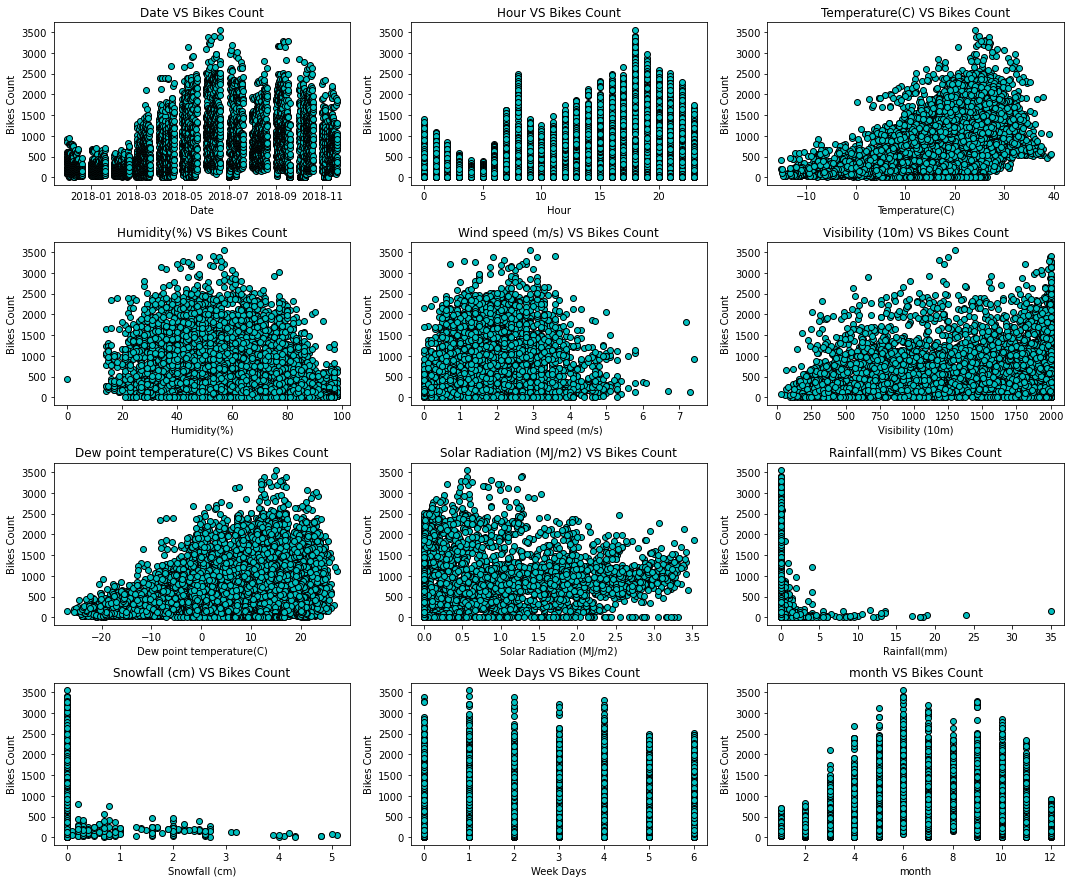

In [78]:
i = 1
plt.figure(figsize = [15, 15], tight_layout = 5)
for column in visualization_df.drop(['y'], axis=1).columns:
    plt.subplot(5, 3, i)
    plt.scatter(data = visualization_df, x = column, y = 'y', c='c', edgecolors='black')
    plt.xlabel(column)
    plt.ylabel('Bikes Count')
    plt.title(column + ' VS ' + 'Bikes Count')
    i += 1
plt.show()

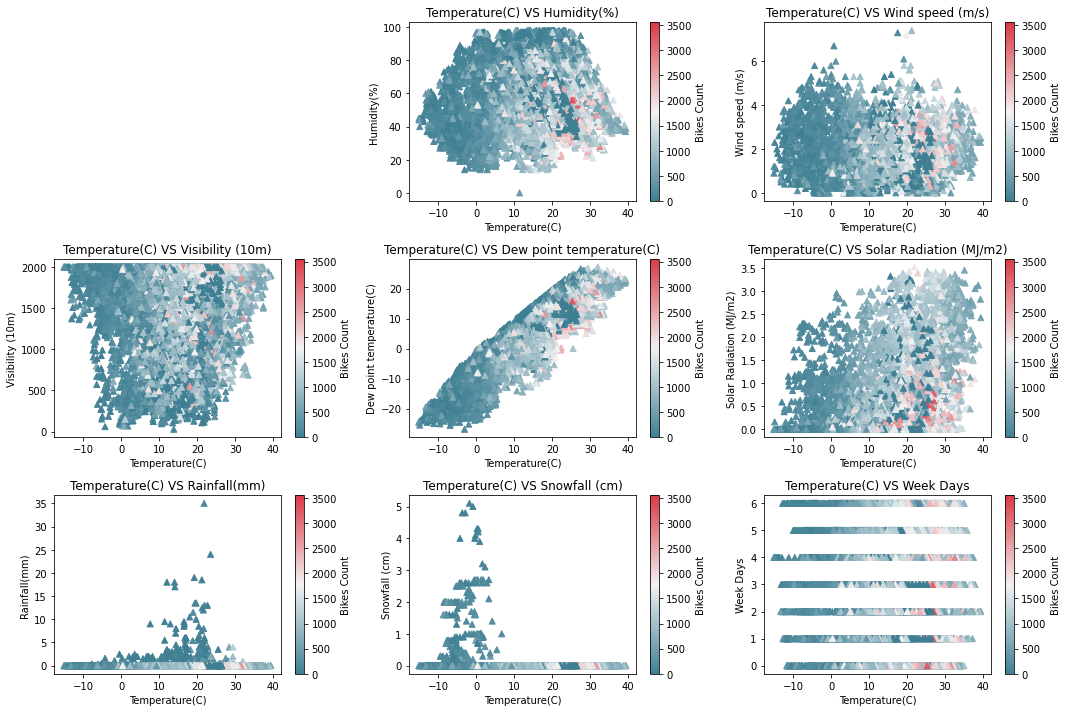

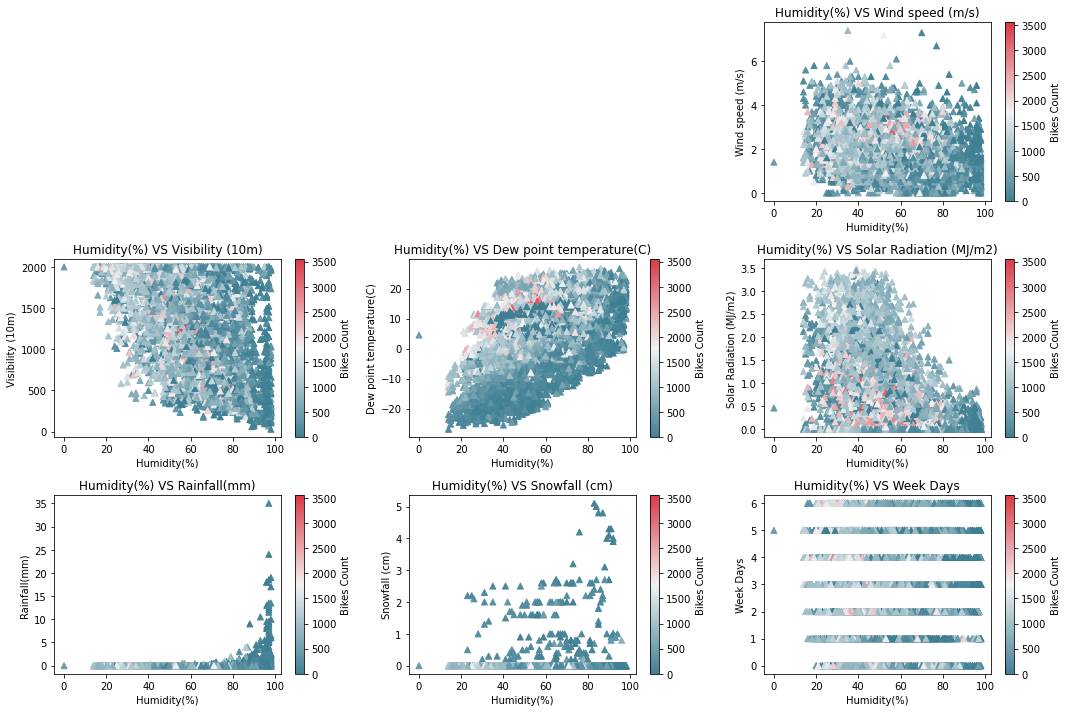

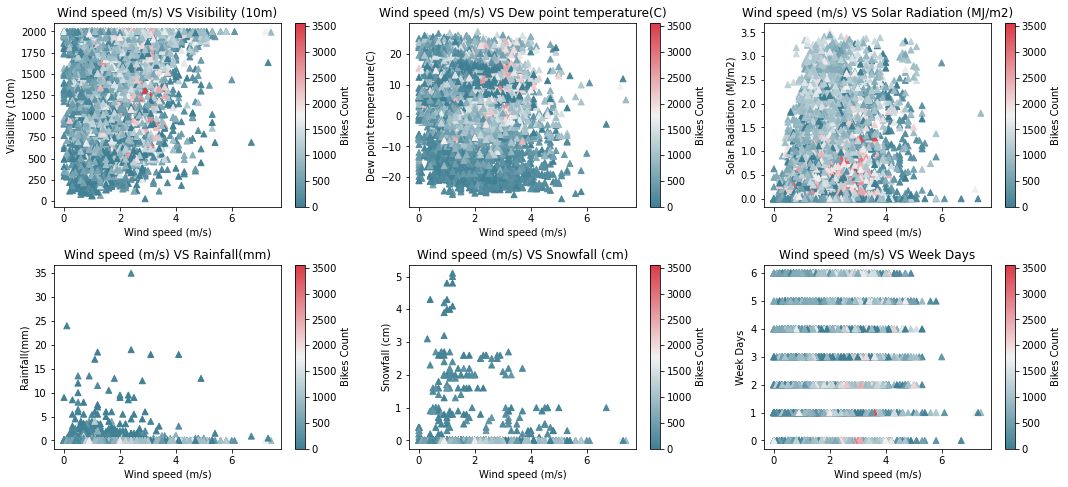

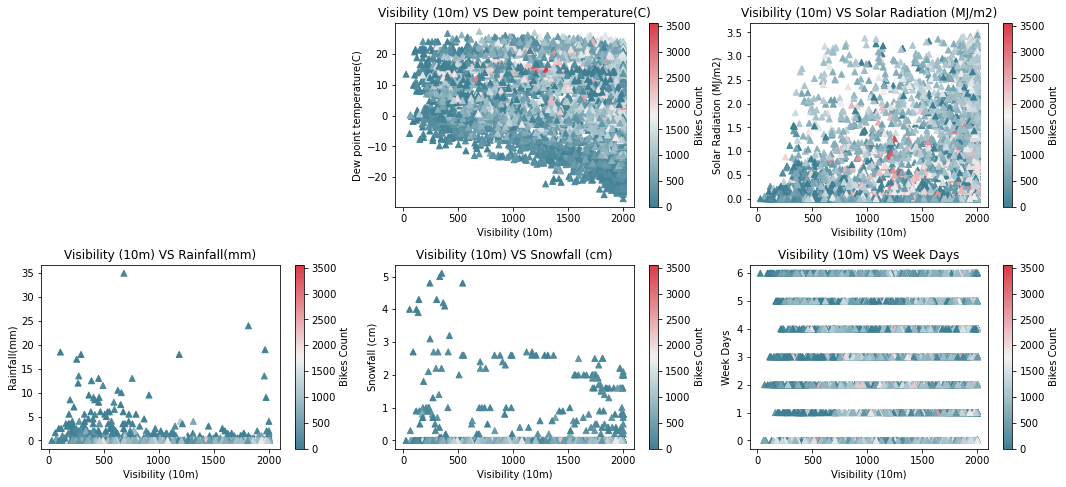

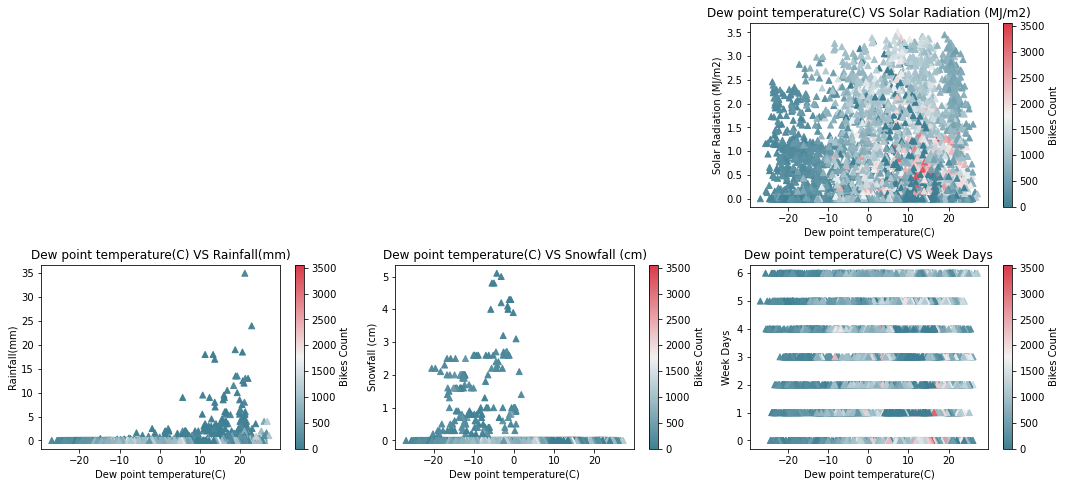

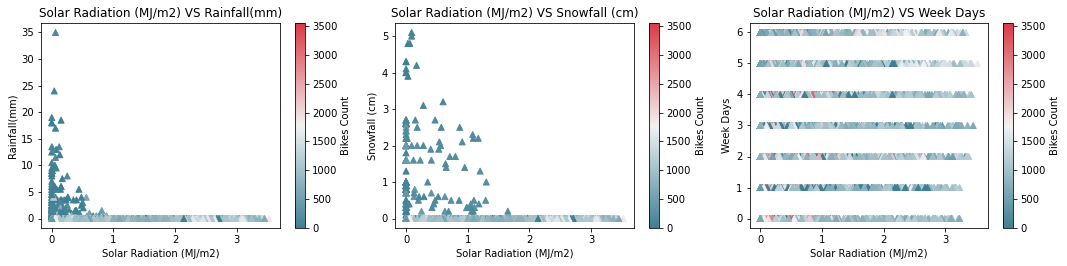

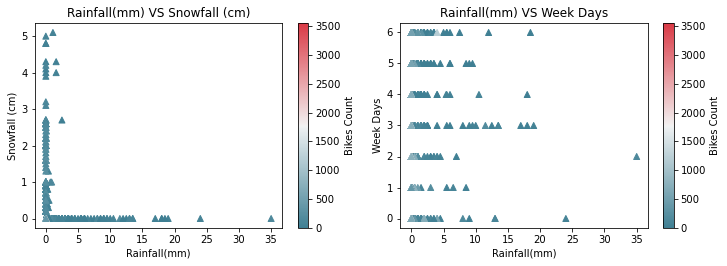

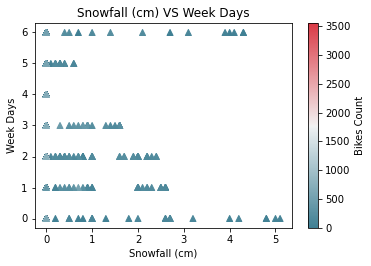

<Figure size 1080x720 with 0 Axes>

In [80]:
cols = visualization_df[[
        'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)'
        , 'Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'
        , 'Week Days'
    ]].columns

for i in range(len(cols)):
    plt.figure(figsize = [15, 10],  tight_layout = 5)
    for j in range(i+1, len(cols)):
        plt.subplot(3, 3, j+1)
        plt.scatter(data = visualization_df, x = cols[i], y = cols[j], c = 'y', 
                    cmap = sns.diverging_palette(220, 10, as_cmap=True), marker='^')
        plt.colorbar(label = 'Bikes Count')
        plt.xlabel(cols[i])
        plt.ylabel(cols[j])
        plt.title(cols[i] + ' VS ' + cols[j])
plt.show()

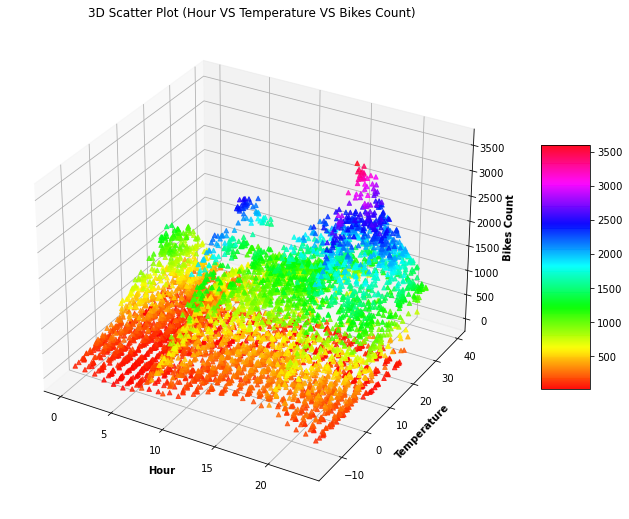

In [82]:
# %matplotlib qt

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

my_cmap = plt.get_cmap('hsv')
 
sctt = ax.scatter3D(df['Hour'], df['Temperature(C)'], df['y'],
                    alpha = 0.8,
                    c = (df['Hour']+ df['Temperature(C)']+ df['y']),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("3D Scatter Plot (Hour VS Temperature VS Bikes Count)")
ax.set_xlabel('Hour', fontweight ='bold')
ax.set_ylabel('Temperature', fontweight ='bold')
ax.set_zlabel('Bikes Count', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

## Feature Engineering

- getting the rush hour and Dead Hours of our DF

In [37]:
def rush_hour(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
        
def dead_hour(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0 

- getting The state of the Day , night or morning

In [38]:
day_state = lambda df : 1  if (df['Hour'] >=6 and df['Hour'] <=18) else 0

In [39]:
humidex = lambda df : df['Temperature(C)'] + (5/9) *\
(6.11 * np.exp(5417.7530 * (1/273.16-(1/(273.15 + df['Dew point temperature(C)']) ) ) ) -10)

# get the high Humidity 
Humidity_high = lambda df : 0 if (df['Humidity(%)'] <= 70) else 1

- Visibility Clustering into classes.

In [40]:
#To change 
#remove unsed
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
#To change 
#visibility_dist:visibility_Status
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5

#### Rain
- creating a feature to see Sky state (Rain And SnowFall ) to conclude if it rains, snows or not.

In [41]:
rain_fall = lambda df : 0 if df['Rainfall(mm)'] < 0.5 else 1
snow_fall = lambda df : 0 if df['Snowfall (cm)'] == 0 else 1

In [42]:
Bad_Weather = lambda df :0 \
if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) \
else 1

High_temperature = lambda df : 0 if (df['Temperature(C)'] <= 35) else 1


Ideal = lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0

- Manually Putting the Weather State

In [43]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
    
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

In [44]:
Weather_State = lambda df:\
                "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0

Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']


length = len(Weather_Description_list) + 1
Weather_Description_neumeric = [*range(1, length, 1)]

- Manually Putting the Sky State

In [45]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    
# mist and fog 
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0
    
#Rain State 
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
    
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0
#Snow State
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

- Clustering Sky States into 5 classes

In [46]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
    
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
    
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
    
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
    
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0
    
Sky_State = lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5

- Clustering the Temperature State

In [47]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
    
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
    
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
    
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0
    
Temp_State = lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 else 5

In [48]:
class FeatureEngineering:
    
    def __init__(self,df):
        self.original_df = df
        self.TransformedDF = self.original_df.copy()
    
    def get_date_attributes(self,Date_Col_name):        
        self.TransformedDF['Year'] = self.original_df[Date_Col_name].dt.year.astype('int')
        self.TransformedDF['Week'] = self.original_df[Date_Col_name].dt.isocalendar().week.astype('int')
        self.TransformedDF['Month'] = self.original_df[Date_Col_name].dt.month.astype('int')
        self.TransformedDF['WeekDay'] = self.original_df[Date_Col_name].dt.weekday.astype('int')
        
    def new_feature(self,function,new_col_name):
        self.TransformedDF[new_col_name]  = self.TransformedDF.apply(function,axis=1)
        
    def map_colmun_to_Categorical(self,new_col_name,from_vals,to_vals):
        self.TransformedDF[new_col_name].replace(from_vals,to_vals,inplace=True)
        
    def CreateLag(self,used_col,shift = -1):
        col_name = f'{used_col}_shift({shift})'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].shift(shift)
        self.TransformedDF[col_name].fillna(0, inplace=True)
    
    def CreateRoll(self,used_col,roll = 4):
        col_name = f'{used_col}_rolling({roll}With_Mean)'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].rolling(roll).mean()
        self.TransformedDF[col_name].fillna(0, inplace=True)
        
    def CreateEWM(self,used_col,com = 0.9):
        col_name = f'{used_col}_EWM_Com({com}With_Mean)'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].ewm(com=com).mean()
        self.TransformedDF[col_name].fillna(0, inplace=True)

In [49]:
def Transform(df):
    Transformed  = FeatureEngineering(df)
    Transformed.get_date_attributes('Date')
    
    # map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])
    Transformed.map_colmun_to_Categorical('Functioning Day',['Yes','No'],[1,0])
    Transformed.map_colmun_to_Categorical('Holiday',['Holiday','No Holiday'],[1,0])
    Transformed.map_colmun_to_Categorical('Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])
    
    #Create Rush and Dead hour
    Transformed.new_feature(rush_hour,'Rush_hour')
    Transformed.new_feature(dead_hour,'Dead_hour')
    
    #Get morinig or Night
    #TO change
    #day_night:morninig and night
    Transformed.new_feature(day_state,'day_night')
    
    #Humidity_high
    Transformed.new_feature(Humidity_high,'Humidity_high')
    
    #Hight Temp
    Transformed.new_feature(High_temperature,'Temperature_high')
    
    #Bad wether
    Transformed.new_feature(Bad_Weather ,'Weather_bad')

    #Create Humidex
    Transformed.new_feature(humidex,'Humidex') 
    
    #Ideal Weather
    Transformed.new_feature(Ideal,'Ideal')
    
    #Visability 
    #To change 
    #Visibility_cat > remove 
    Transformed.new_feature(visibility,'Visibility_cat')
    
    #visibility states
    Transformed.new_feature(visibility_dist,'Visibility_dist')
    
    #Rain or Snow 
    #To change 
    #Rain Snow _ cat > isRain , isSnow 
    Transformed.new_feature(rain_fall,'Rain_cat')
    Transformed.new_feature(snow_fall,'Snow_cat')
    
    #Weather State
    Transformed.new_feature(Weather_State,'Weather_State')
    
    #Categorical Weather State
    Transformed.map_colmun_to_Categorical('Weather_State',Weather_Description_list
                                          ,Weather_Description_neumeric)
    #to Change 
    #Weather_stat&visb_dist : Weather_stat@visibility_Status
    Transformed.new_feature(lambda df :df['Weather_State']*(df['Visibility_dist'])
                            ,'Weather_stat&visb_dist') # Weather_stat@visb_dist
    
    #To change
    #Weather&visb : #Weather_stat@log(visability)
    
    Transformed.new_feature( lambda df :df['Weather_State']*np.log(df['Visibility (10m)']) 
                      ,'Weather&visb') #Weather_stat@log(visb)
    
    #Sky_State
    Transformed.new_feature(Sky_State,'Sky_State')
    #Temp_State
    Transformed.new_feature(Temp_State,'Temp_State')
    
    #play ground 
    #To change 
    #GBL_Forecast : Sky_State_@_Temp_State
    Transformed.new_feature(lambda df :df['Sky_State']*(df['Temp_State'])
                            ,'GBL_Forecast') #Sky_State_@_Temp_State

    #Lag Play Groun
    ColsForLag =  ["Temperature(C)" ,"Rainfall(mm)" ,"Visibility (10m)"
                , "Wind speed (m/s)","Weather_State","Humidity(%)","Rush_hour","Dead_hour","Ideal" 
                   ,"Dew point temperature(C)"]
    #To change 
    #Temperature lag1:Temperature(C)_shift(-1)
    #any Roll f'{used_col}_rolling({roll}With_Mean)'
    #any EWM f'{used_col}_EWM_Com({com}With_Mean)'
    t  = -1
    for col in ColsForLag:
        Transformed.CreateLag(col,(t))
        
    for col in ColsForLag:
        Transformed.CreateLag(col,(t-1))
        
    for col in ColsForLag:
        Transformed.CreateLag(col,(t-2))

    for col in  ColsForLag:
        Transformed.CreateRoll(col,4)

    for col in  ColsForLag:
        Transformed.CreateEWM(col,0.9)


    return Transformed.TransformedDF

####  Our Scoring Metric (RMSLE)

In [50]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = 10**(y_true)
        y_pred = 10**(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 
Scoring = rmsle_scorer

- Selecting the upcoming features to apply the lag of -1 on them. Lag is applied to know the future of the current features, as what happens always on google climate you can always know the temperature in the coming hours.

In [51]:
ColsForLag =  ["Temperature(C)" ,"Rainfall(mm)" ,"Visibility (10m)"
            , "Wind speed (m/s)","Weather_State","Humidity(%)","Rush_hour","Dead_hour","Ideal" 
               ,"Dew point temperature(C)"]

In [52]:
lag1_features , lag2_features , lag3_features , rolling_features,ewn_features = [],[],[],[],[]
t = -1

for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t})'
    lag1_features.append(col_name)
    
for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t-1})'
    lag2_features.append(col_name)
    
for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t-2})'
    lag3_features.append(col_name)

for used_col in ColsForLag:
    col_name = f'{used_col}_rolling({4}With_Mean)'
    rolling_features.append(col_name)

for used_col in ColsForLag:
    col_name = f'{used_col}_EWM_Com({0.9}With_Mean)'
    ewn_features.append(col_name)

In [53]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score



In [54]:
original_features=['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',"Dew point temperature(C)",
                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
                     'Functioning Day']


weather_features=['Rush_hour','Dead_hour','Weather_State',
                     'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast']

selected_features = original_features + weather_features + lag1_features + lag2_features + lag3_features + rolling_features + ewn_features

train = Transform(df)

train["y"] = np.log10(train["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state=42,shuffle=True)

---
## CatBoost Model Training


In [55]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE',random_state=0,max_depth=4,iterations=3200,
                                           l2_leaf_reg=1,learning_rate=0.038,subsample=0.85)


model.fit(X_train,y_train)
pred_test = model.predict(X_test)
pred_train= model.predict(X_train)

print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))


0:	learn: 1.5393433	total: 5.14ms	remaining: 16.4s
1:	learn: 1.4853103	total: 8.51ms	remaining: 13.6s
2:	learn: 1.4346246	total: 14.7ms	remaining: 15.6s
3:	learn: 1.3850945	total: 18.6ms	remaining: 14.8s
4:	learn: 1.3387455	total: 22ms	remaining: 14s
5:	learn: 1.2933698	total: 26.8ms	remaining: 14.3s
6:	learn: 1.2489450	total: 31.9ms	remaining: 14.6s
7:	learn: 1.2060426	total: 35.7ms	remaining: 14.2s
8:	learn: 1.1643927	total: 39.2ms	remaining: 13.9s
9:	learn: 1.1257802	total: 45.1ms	remaining: 14.4s
10:	learn: 1.0882093	total: 49.5ms	remaining: 14.3s
11:	learn: 1.0514227	total: 53.1ms	remaining: 14.1s
12:	learn: 1.0162711	total: 56.9ms	remaining: 13.9s
13:	learn: 0.9821276	total: 61.9ms	remaining: 14.1s
14:	learn: 0.9502585	total: 65.4ms	remaining: 13.9s
15:	learn: 0.9186813	total: 69.1ms	remaining: 13.7s
16:	learn: 0.8900276	total: 74ms	remaining: 13.9s
17:	learn: 0.8613661	total: 79.1ms	remaining: 14s
18:	learn: 0.8339801	total: 83.4ms	remaining: 14s
19:	learn: 0.8071273	total: 86.8

In [56]:
print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))

(Test) CatBoost Regression RMSLE: 0.20822181444328952
(Train) CatBoost Regression RMSLE: 0.08467485097181301


---
<a id='Model_Prediction'></a>
### Model Predictions
### [Jump Top](#Jump)

In [57]:
y_test_st = model.predict(X_test)
y_train_st = model.predict(X_train)

print('CatBoost RMSLE Test: ', rmsle(y_test, y_test_st, True))
print('CatBoost RMSLE Train: ', rmsle(y_train, y_train_st, True))

print('CatBoost R2 Test: ', r2_score(y_test, y_test_st))
print('CatBoost R2 Train: ', r2_score(y_train, y_train_st))

CatBoost RMSLE Test:  0.20822181444328952
CatBoost RMSLE Train:  0.08467485097181301
CatBoost R2 Test:  0.9971110169212831
CatBoost R2 Train:  0.9994503498083646


In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
k_folds = KFold(n_splits=7)
cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, verbose = 2, cv=k_folds, scoring=rmsle_scorer)
print(f'CatBoost cv_error : {-cv_score.mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   50.7s remaining:   38.0s


CatBoost cv_error : 0.22809228664926898


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.4min finished


In [59]:
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X_test, y_test, scoring=rmsle_scorer, cv=cv, n_jobs=-1)

In [60]:
#-scores.mean()

In [61]:
save_to_path = r'submission.csv'

In [62]:
test = Transform(df_test)

In [63]:
test['y'] =  10**(model.predict(test[selected_features]))
test[["ID", "y"]].to_csv(save_to_path, index=False)

In [64]:
test.y

0       127.341257
1       119.776008
2       100.010054
3        62.314260
4        44.156062
           ...    
2995    994.599761
2996    746.280742
2997    699.924993
2998    599.610334
2999    309.345931
Name: y, Length: 3000, dtype: float64